# Imports and Constants

## Imports

In [1]:
import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from wordcloud import WordCloud

IPython magic and widgets:

In [3]:
%matplotlib inline
plt.rcParams["figure.dpi"] = 100
%config InlineBackend.figure_formats = ['retina']

In [4]:
from IPython.display import display, clear_output, IFrame
import ipywidgets as widgets

## Constants

In [5]:
TRANSFORMED_DATA_PATH = "../transformed_data/"
TRANSFORMED_FILES = os.listdir(TRANSFORMED_DATA_PATH)
TRANSFORMED_FILES_PATH = dict(zip(TRANSFORMED_FILES, [os.path.join(TRANSFORMED_DATA_PATH, file) for file in TRANSFORMED_FILES]))

In [6]:
TRANSFORMED_FILES

['df_trump.csv', 'df_hillary.csv', 'df_ferguson.csv', 'df_samesex.csv']

In [7]:
ORIGINAL_DATA_PATH = "../original_data/"
ORIGINAL_FILES = os.listdir(ORIGINAL_DATA_PATH)
ORIGINAL_FILES_PATH = dict(zip(ORIGINAL_FILES, [os.path.join(ORIGINAL_DATA_PATH, file) for file in ORIGINAL_FILES]))

In [8]:
ORIGINAL_FILES

['ferguson_anonymise_cleaned.csv',
 'same_sex_tweets_for_textanalsis-splitted',
 'trump_tweets_for_textanalsis.csv',
 'trump_anonymise_cleaned.csv',
 'same_sex_anonymise_cleaned.csv',
 'hillary_anonymise_cleaned.csv']

Color palette for republican and democrats:

In [9]:
COLORS_REPUBLICAN = ["red",'#8B0000']
COLORS_DEMOCRATS = ["deepskyblue","navy"]

Matplotlib figure size:

In [10]:
FIGSIZE = (10,5)

# Trump Dataset

## A. Preprocessing of `trump_anonymise_cleaned.csv`

Loading `trump_anonymise_cleaned.csv` in `df_trump`:

In [11]:
df_trump = pd.read_csv(ORIGINAL_FILES_PATH['trump_anonymise_cleaned.csv'])
df_trump = df_trump.drop(df_trump.columns[0], axis=1)

Reverting logarithmic transform of retweets and likes:

In [12]:
df_trump[['retweets_log','likes_log']] = np.exp(df_trump[['retweets_log','likes_log']]).subtract(1).astype(int)
df_trump = df_trump.rename(columns={'retweets_log': 'retweets', 'likes_log': 'likes'})

Printing first five rows:

In [13]:
df_trump

,user_id,tweet_id,retweets,likes,followers,time,sen_pos,sen_neg,binary_affiliation
0,ATWYMOVRZP,RULEKCGZNF,0,2,20919,2016-11-09 18:43:58,0,3,NaN
1,JARDVQKMGH,ASVFDYRELQ,0,0,402,2016-11-09 16:06:59,1,0,NaN
2,GCUZERVKIS,NOFDYISPBE,0,0,2053,2016-11-11 05:25:50,0,0,NaN
3,XUQCRKIFBS,EMLDKOBYVH,0,0,879,2016-11-09 00:08:06,2,0,NaN
4,VXINQMGRPC,BXQEAPZDYL,0,0,175,2016-11-11 00:46:31,0,0,NaN
...,...,...,...,...,...,...,...,...,...
278183,DUFQXYRJVN,FSBPDHGXLV,0,0,0,2016-11-15 22:11:47,0,0,NaN
278184,OJSDFZQCXR,ESTPJOXHYC,0,0,0,2016-11-15 21:14:15,0,0,NaN
278185,ZEYLSTJPNW,ZIDJXNPLWC,0,0,2,2016-11-15 22:21:15,3,0,NaN
278186,OYUHVXWRPI,YLHMDFQION,0,0,0,2016-11-15 23:51:22,0,0,NaN


## B. Preprocessing of `trump_tweets_for_textanalsis.csv`

Loading `trump_tweets_for_textanalsis.csv` in `df_trumpText`:

In [14]:
df_trumpText = pd.read_csv(ORIGINAL_FILES_PATH['trump_tweets_for_textanalsis.csv'],encoding = "latin")
df_trumpText = df_trumpText.drop(df_trumpText.columns[0], axis=1)

In [15]:
df_trumpText

,retweets,tweet_body,tweet_body_lemmatized,valence
0,1,Hear that MAGA The guy advising you on your r...,hear that maga the guy advise you on your reti...,-1
1,1,Hear that MAGA https tco 4MB2J22RwU,hear that maga https tco 4mb2j22rwu,0
2,0,Hear that MAGA https tco ytfwcmrM8a,hear that maga https tco ytfwcmrm8a,0
3,1,draintheswamp indeed Hear that MAGA Hes selli...,draintheswamp indeed hear that maga hes sell y...,0
4,0,Got that MAGA https tco AXfmBBWmNV,get that maga https tco axfmbbwmnv,0
...,...,...,...,...
405402,0,Todays a good day to stay off social medialet ...,today a good day to stay off social medialet a...,-2
405403,2,Boy was I wrong about this election Hopefully ...,boy be i wrong about this election hopefully t...,-1
405404,1,First time millennial voter for realDonaldTrum...,first time millennial voter for realdonaldtrum...,0
405405,0,Great job arizona presidenttrump,great job arizona presidenttrump,2


## C. Trump Tweet Generator

Trump tweet generator for exploratory tweet analysis.

In [16]:
def unshorten_url(url):
    session = requests.Session()  # so connections are recycled
    resp = session.head(url, allow_redirects=True)
    return resp.url

In [17]:
button = widgets.Button(description="Generate tweet")
retweets_slider = widgets.SelectionRangeSlider(
    value=[0, df_trumpText["retweets"].max()],
    options=sorted(df_trumpText["retweets"].unique()),
    description='Retweets:'
)
valence_slider = widgets.SelectionRangeSlider(
    value=[-4,4],
    options=range(-4,5),
    description='Valence:'
)
output = widgets.Output()

display(button,retweets_slider,valence_slider,output)

def on_button_clicked(b):
    with output:
        clear_output(wait=True)
        df_trumpText_sel = df_trumpText[df_trumpText["retweets"].between(retweets_slider.value[0],retweets_slider.value[1]) &\
                                        df_trumpText["valence"].between(valence_slider.value[0],valence_slider.value[1])]
        print(f"There are {df_trumpText_sel.shape[0]:,.0f} total tweets which accumulate {df_trumpText_sel.retweets.sum(0):,.0f} retweets in the selected range.")
        sample = df_trumpText_sel.sample()
        sample_id = sample.index.values[0]
        tweet_text = sample["tweet_body"].values[0]
        print(f"Tweet #{sample_id}: ", tweet_text)
        valence = sample["valence"].values[0]
        print("Valence: ", valence)
        retweets = sample["retweets"].values[0]
        print("Retweets: ", retweets)
        tweet_text_split = tweet_text.split()
        if tweet_text_split[-2] == "tco":
            url = "https://t.co/" + tweet_text_split[-1]
            url = unshorten_url(url)
            print(f"URL:", url)
            if url[8:19] == "twitter.com":
                nitter_url = f"https://nitter.net/{url[20:]}"
                print(f"Nitter URL: {nitter_url}")

button.on_click(on_button_clicked)

Button(description='Generate tweet', style=ButtonStyle())

SelectionRangeSlider(description='Retweets:', index=(0, 1005), options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, …

SelectionRangeSlider(description='Valence:', index=(0, 8), options=(-4, -3, -2, -1, 0, 1, 2, 3, 4), value=(-4,…

Output()

In [18]:
IFrame("https://nitter.net/i/web/status/796266675339292672", width=700, height=1000)

## D. Used DataFrames

### "Per user" DataFrames

Per user Dataframes have names that finish with `_pu`.

Dataframes that describes the number of tweets (with retweets) and the number of original tweets (without retweets) per user:

In [19]:
df_trump_tweets = pd.DataFrame(df_trump['user_id'].value_counts())
df_trump_tweets = df_trump_tweets.rename(columns={'user_id': 'num_tweets'})

df_trump_original_tweets = pd.DataFrame(df_trump.sort_values("time").drop_duplicates(subset="tweet_id",keep='first')['user_id'].value_counts())
df_trump_original_tweets = df_trump_original_tweets.rename(columns={'user_id': 'num_original_tweets'})

df_trump_total_original_tweets = pd.merge(df_trump_tweets, df_trump_original_tweets, left_index=True, right_index=True)

Dataframes that describe the number of followers, accumulated likes and accumulated retweets per user:

In [20]:
df_trump_followers_pu = df_trump.sort_values("time")[['user_id','followers']].drop_duplicates(subset='user_id',keep='last')
df_trump_followers_pu.set_index('user_id', inplace=True)

df_trump_likes_retweets_pu = df_trump.sort_values("time")[['user_id','likes','retweets']]
df_trump_likes_retweets_pu = df_trump_likes_retweets_pu.groupby('user_id').agg({'likes':'sum','retweets':'sum'})

Dataframe that combines all per user dataframes:

In [21]:
df_trump_pu = pd.merge(df_trump_followers_pu, df_trump_likes_retweets_pu, left_index=True, right_index=True)
df_trump_pu = pd.merge(df_trump_total_original_tweets, df_trump_pu, left_index=True, right_index=True)
df_trump_pu.index.name = 'user_id'

df_trump_pu

,num_tweets,num_original_tweets,followers,likes,retweets
user_id,,,,,
ENWKGSIYMD,654,195,981,170,98
ENTXBCHMYQ,477,102,4565,849,467
VERNTAGDOH,453,387,570,430,517
NKVXWRCMET,433,416,761,331,238
DTMNPRLZVJ,400,18,1490,54,20
...,...,...,...,...,...
OJWUMIDRYS,1,1,55,0,0
NYCQOXSIMP,1,1,17866,0,0
AUQNZYVCGJ,1,1,2813,0,0


### "Per tweet" DataFrames

Per tweet Dataframes have names that finish with `_pt`.

In [22]:
df_trump_pt = df_trump[["tweet_id","retweets","likes","sen_pos","sen_neg"]].groupby('tweet_id').agg({'retweets':'sum','likes':'sum','sen_pos':'mean','sen_neg':'mean'})
assert df_trump_pt[~pd.to_numeric(df_trump_pt['sen_pos'], errors='coerce').notna()].empty
df_trump_pt = df_trump_pt.astype({"sen_pos": int, "sen_neg": int})

df_trump_pt

,retweets,likes,sen_pos,sen_neg
tweet_id,,,,
ABCDTJHKMQ,0,0,2,0
ABCDUPRJYN,0,0,1,0
ABCDVHWYNJ,0,3,2,3
ABCDWTZYXR,0,0,0,3
ABCFLRPZNY,4,11,0,3
...,...,...,...,...
ZYXSQWDJCR,0,0,1,0
ZYXUREDHJV,0,1,0,1
ZYXVDBTHSF,0,0,0,0


## E. Used Variables

Variable that returns which columns have `NaN` values:

In [23]:
trump_col_has_NaN = dict(zip(df_trump.columns.values, [df_trump[col].isnull().values.any() for col in df_trump.columns]))
for col in trump_col_has_NaN:
    print(f"{col:>20}: {trump_col_has_NaN[col]}")

             user_id: True
            tweet_id: False
            retweets: False
               likes: False
           followers: False
                time: False
             sen_pos: False
             sen_neg: False
  binary_affiliation: True


Non `NaN` user ids, unique users, average tweets (with retweets) per user, average original (without retweets) tweet per user:

In [24]:
trump_num_non_NaN_users = df_trump['user_id'].count()
trump_num_unique_users = df_trump['user_id'].nunique()
trump_num_tweets = df_trump.shape[0]
trump_num_original_tweets = df_trump_original_tweets.sum(0)[0]

## 1. Analysis of originality of tweets

Some statistics:

In [25]:
print(f"{'Total users ids':<40} {trump_num_non_NaN_users:,.0f}",
      f"{'Unique users ids':<40} {trump_num_unique_users:,.0f}",
      f"{'Unique users percentage':<40} {trump_num_unique_users/trump_num_non_NaN_users:.2%}",
      "\n",
      f"{'Total tweets':<40} {trump_num_tweets:,.0f}",
      f"{'Original tweets':<40} {trump_num_original_tweets:,.0f}",
      f"{'Original tweets percentage':<40} {trump_num_original_tweets/trump_num_tweets:.2%}",
      "\n",
      f"{'Average tweet per user':<40} {trump_num_tweets/trump_num_unique_users:.5}",
      f"{'Average original tweet per user':<40} {trump_num_original_tweets/trump_num_unique_users:.5f}",
      sep="\n")

Total users ids                          278,187
Unique users ids                         115,920
Unique users percentage                  41.67%


Total tweets                             278,188
Original tweets                          222,744
Original tweets percentage               80.07%


Average tweet per user                   2.3998
Average original tweet per user          1.92153


Comparison between the amount of original tweets and the amound of retweets:

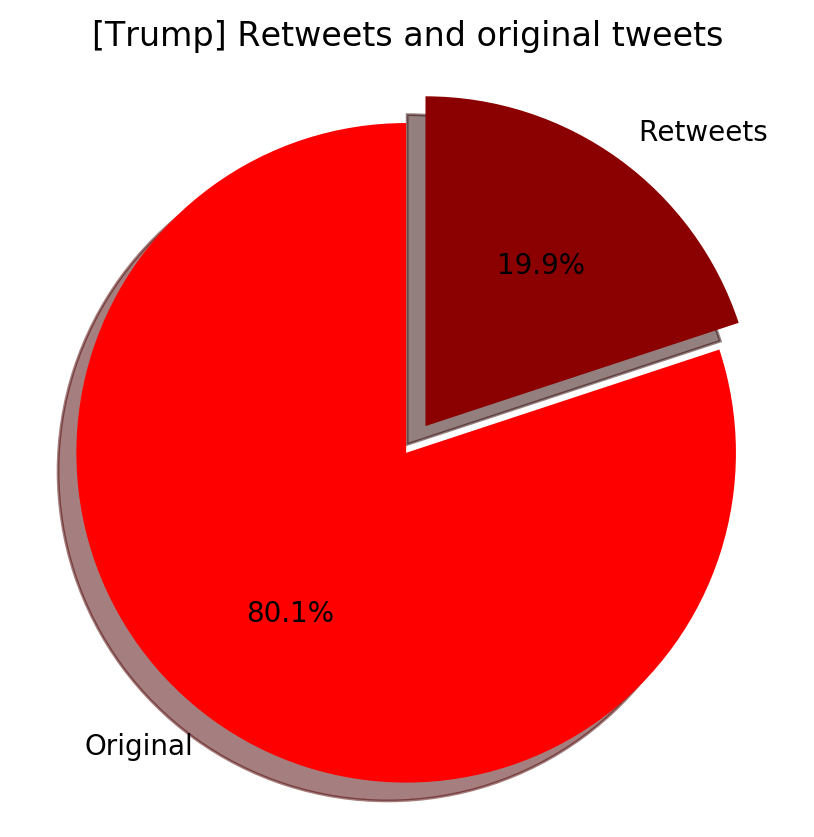

In [26]:
labels = "Original", "Retweets"
sizes = [trump_num_original_tweets, trump_num_tweets - trump_num_original_tweets]
explode = (0.1, 0)

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, explode=explode, labels=labels, shadow=True, startangle=90, autopct='%1.1f%%',colors=COLORS_REPUBLICAN)
ax1.axis('equal')
ax1.set(title="[Trump] Retweets and original tweets")
del labels, sizes, explode

Amount of total tweets and original tweets of top 300 users with most tweets:

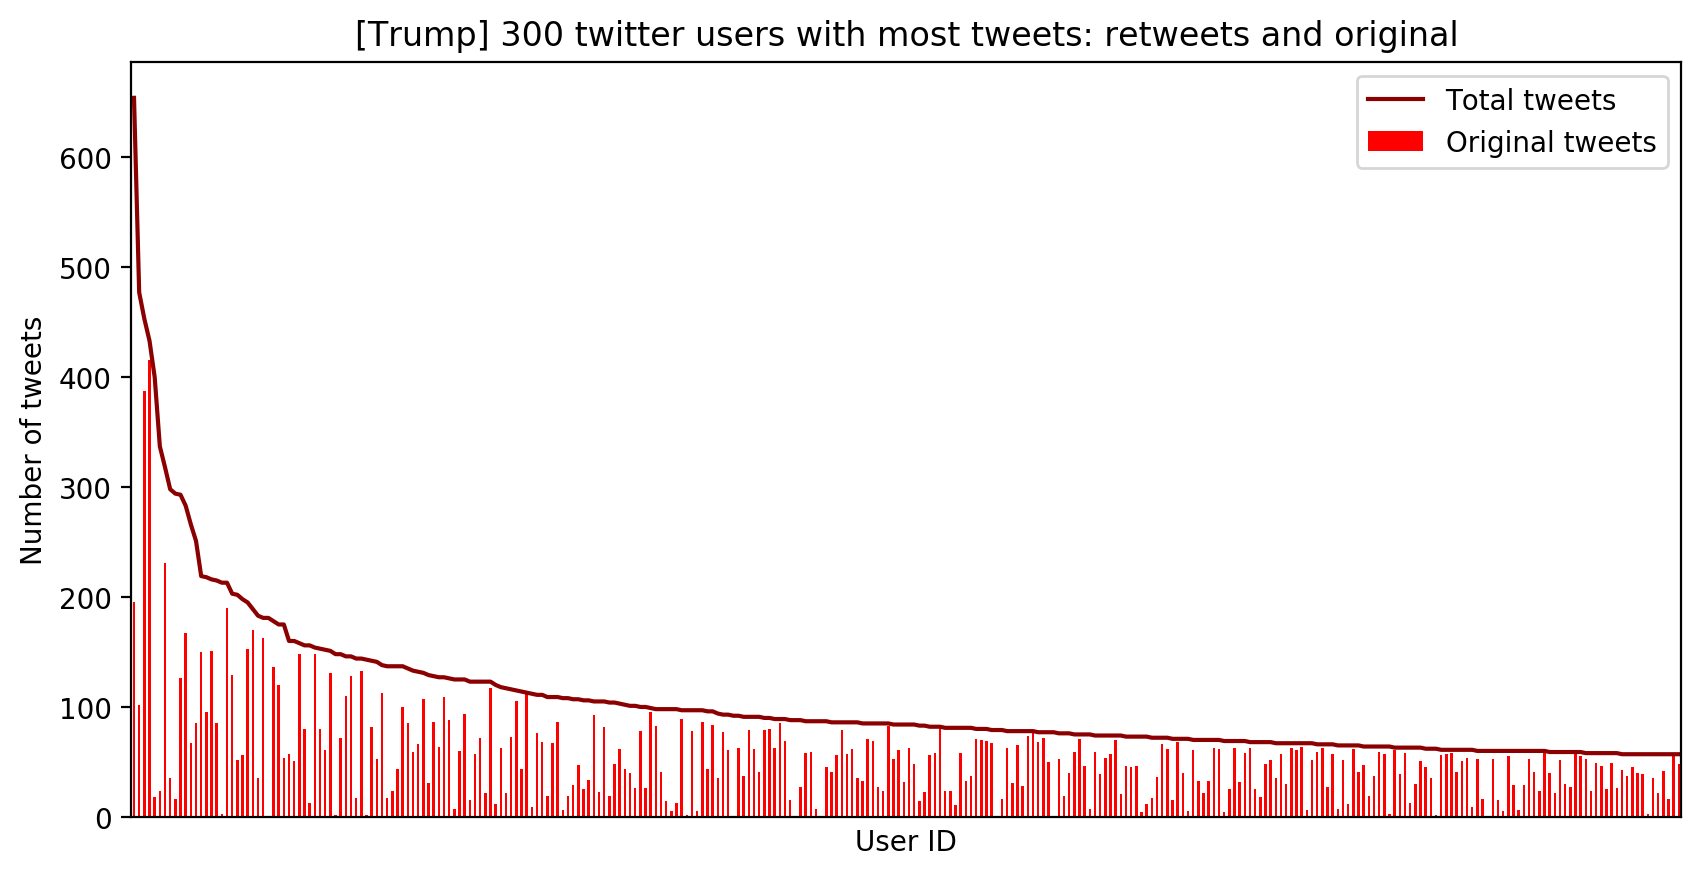

In [27]:
df = df_trump_total_original_tweets.head(300)
fig1, ax1 = plt.subplots(figsize=FIGSIZE)
df["num_tweets"].plot(ax=ax1, xticks=[], label="Total tweets", color=COLORS_REPUBLICAN[1])
df["num_original_tweets"].plot(ax=ax1, xticks=[], kind='bar', label="Original tweets", color=COLORS_REPUBLICAN[0])
ax1.legend()
ax1.set(title=f"[Trump] 300 twitter users with most tweets: retweets and original", xlabel="User ID", ylabel="Number of tweets")
del df

## 2. Analysis of accumulated tweets, followers, likes, retweets per user

Some statististics:

In [28]:
print(f"{' ':20}{'min':>5}{'max':>15}{'mean':>15}{'median':>15}{'std.-dev.':>15}")
for column in df_trump_pu:
    current_column = df_trump_pu[column]
    print(f"{column:^20}{current_column.min():>5}{current_column.max():>15,.0f}{current_column.mean():>15,.1f}{current_column.median():>15,.0f}{current_column.std():>15,.1f}")

                      min            max           mean         median      std.-dev.
     num_tweets         1            654            2.4              1            7.4
num_original_tweets     1            416            1.9              1            4.6
     followers          0     16,468,857        3,174.3            253       94,125.2
       likes            0        171,168           19.3              1          967.6
      retweets          0        118,697           10.4              0          541.0


Plot that show the skewness of the data:

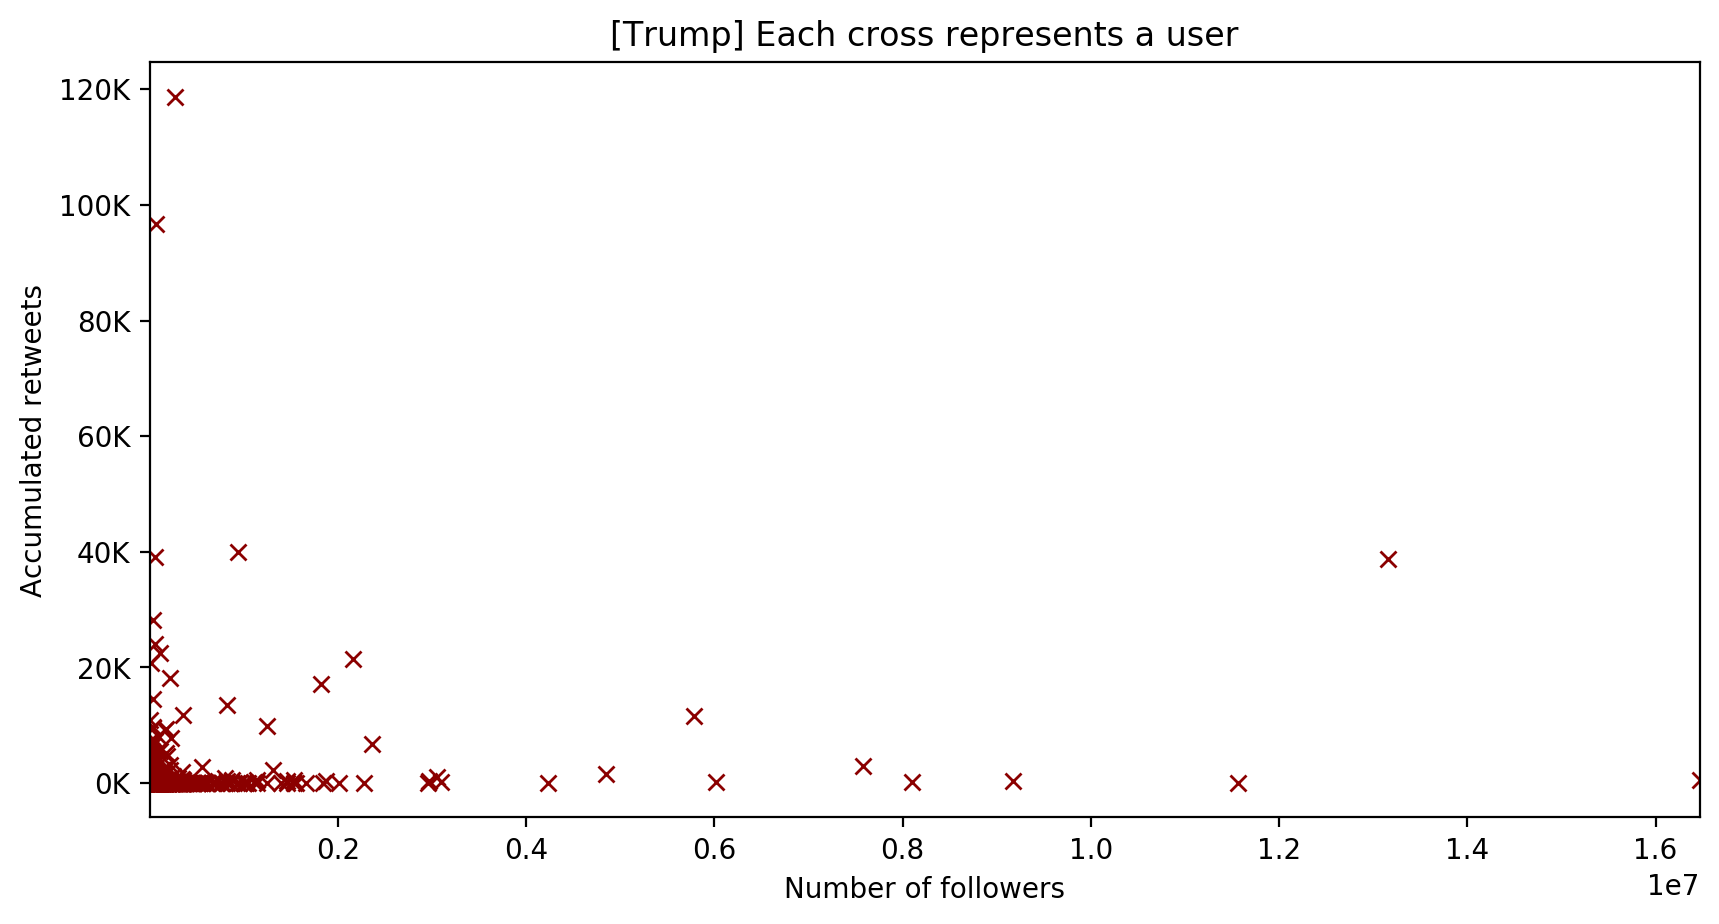

In [29]:
df = df_trump_pu
df = df[df["likes"] >= 1]
sizes = df['likes'].clip(upper=100000) /100
fig1, ax1 = plt.subplots(figsize=FIGSIZE)
ax1.plot(df['followers'].values, df['retweets'].values, marker="x", linestyle="None", c=COLORS_REPUBLICAN[1]);
ax1.set_xlim([1, df['followers'].max()])
ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax1.get_yticks()/1000]
ax1.set_yticklabels(ylabels)
ax1.set(xlabel="Number of followers",ylabel="Accumulated retweets",title="[Trump] Each cross represents a user")
del df, sizes

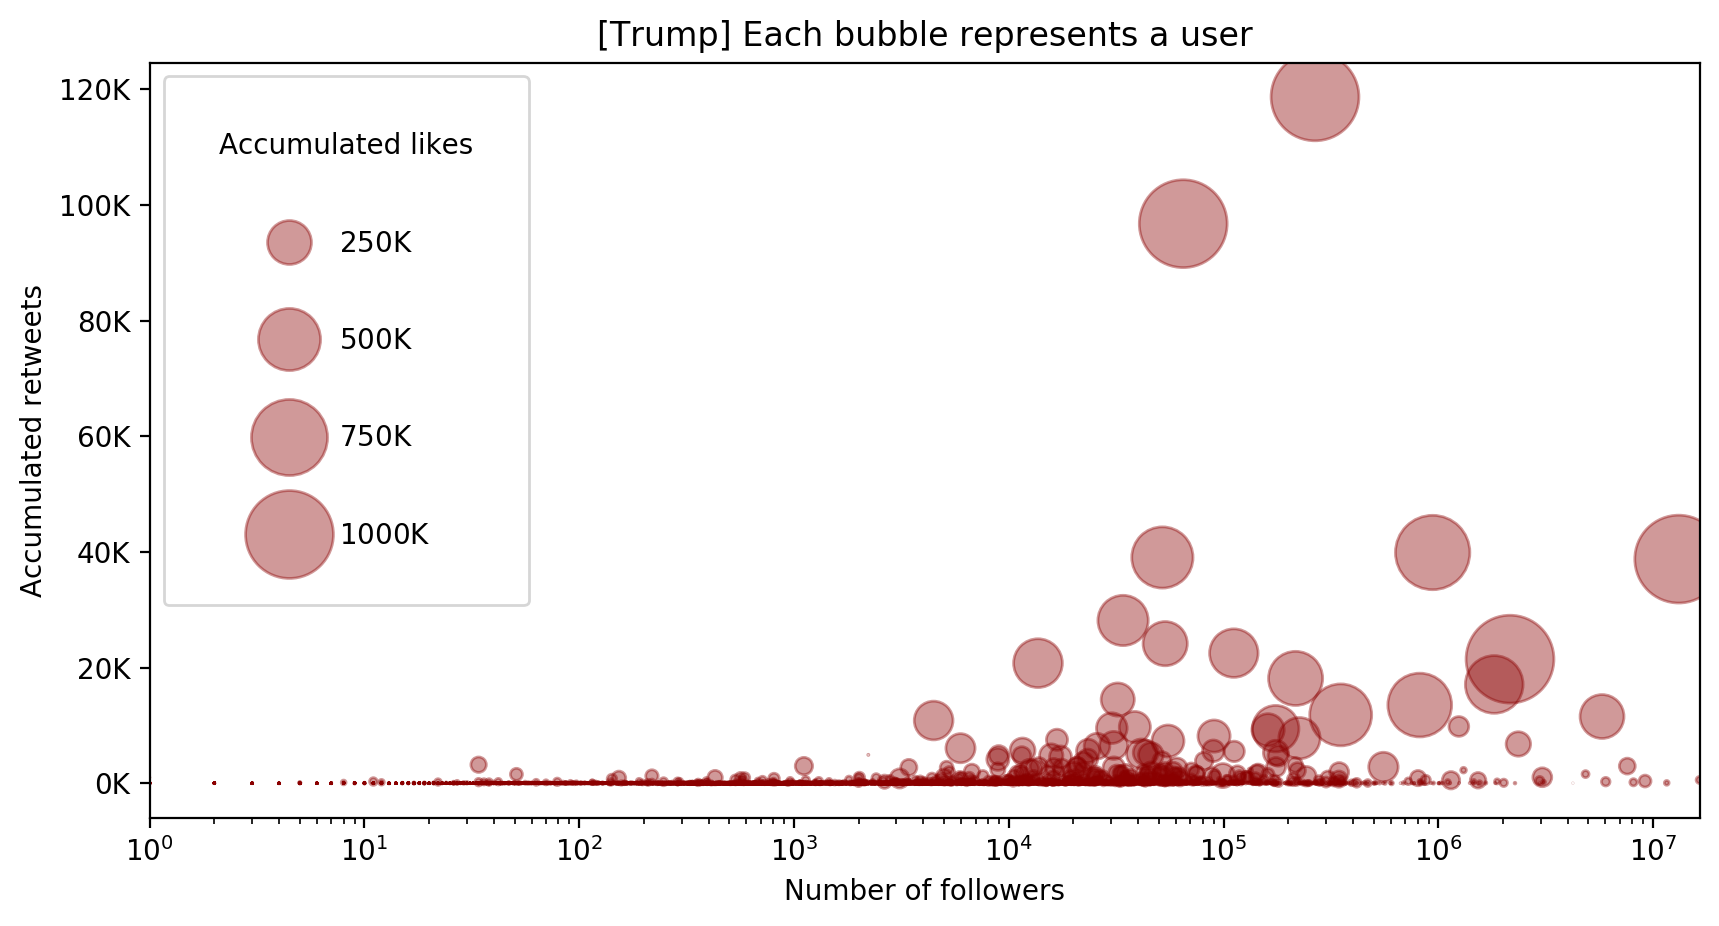

In [30]:
df = df_trump_pu
df = df[df["likes"] >= 1]
sizes = df['likes'].clip(upper=100000) /100
fig1, ax1 = plt.subplots(figsize=FIGSIZE)
sc = ax1.scatter(x = df['followers'].values, y = df['retweets'].values, s = sizes.values, c=COLORS_REPUBLICAN[1], alpha=0.4);
ax1.set_xlim([1, df['followers'].max()])
ax1.set_xscale('log')
ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax1.get_yticks()/1000]
ax1.set_yticklabels(ylabels)
legend_elements = sc.legend_elements("sizes", num=4, c=COLORS_REPUBLICAN[1])
for i,legend_label in enumerate(legend_elements[1]):
    legend_elements[1][i] = legend_label+'K'
ax1.legend(*legend_elements, title="Accumulated likes", labelspacing=2.5, borderpad=2)
ax1.set(xlabel="Number of followers",ylabel="Accumulated retweets",title="[Trump] Each bubble represents a user")
del df, sizes, legend_elements

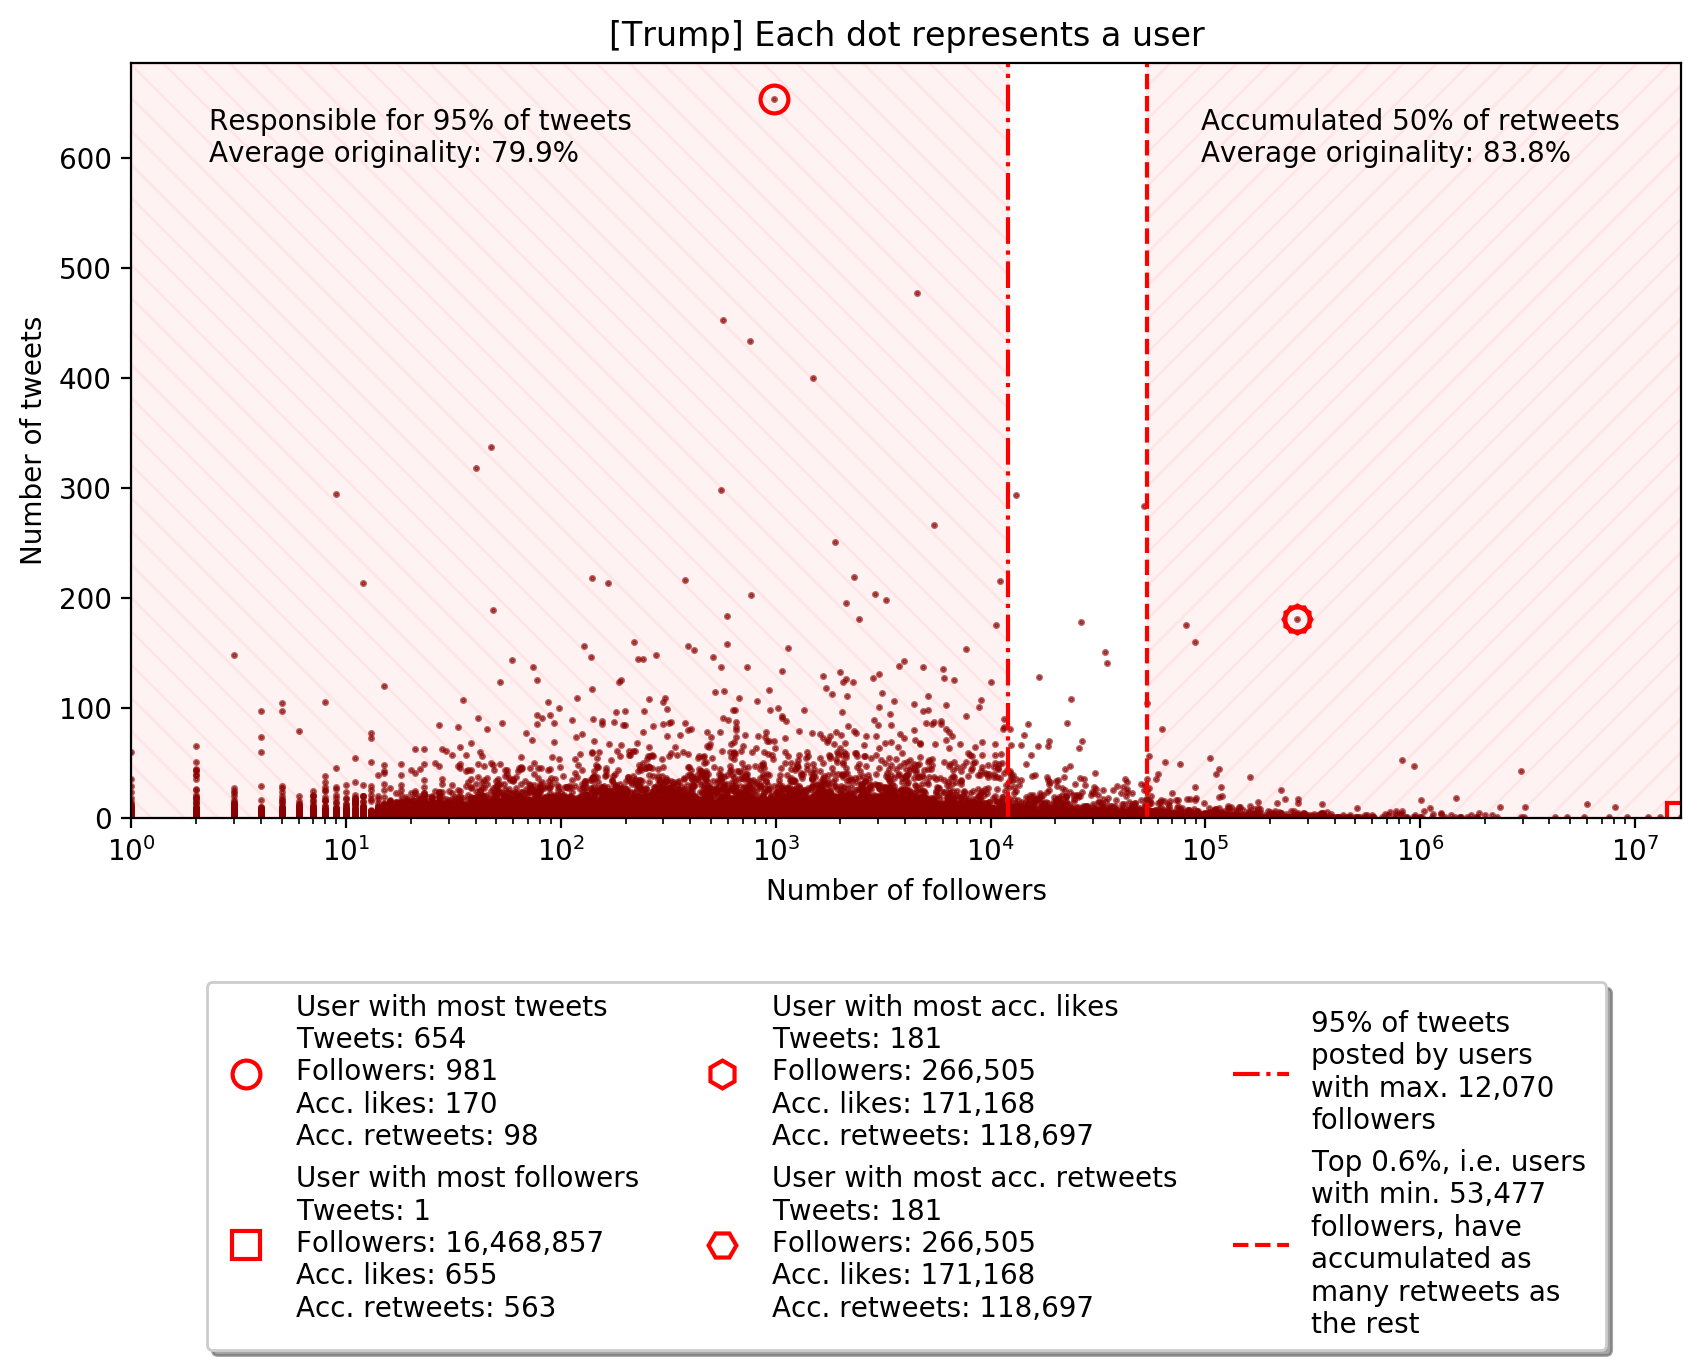

In [31]:
df = df_trump_pu.sort_values("followers")
df = df[(df["followers"] >= 1)]

fig1, ax1 = plt.subplots(figsize=FIGSIZE)

ax1.plot(df['followers'].values, df['num_tweets'].values, '.', color=COLORS_REPUBLICAN[1], markersize=3, alpha=0.6)

ax1.set_xlim([1, df['followers'].max()])
ax1.set_ylim(ymin=0)
ax1.set_xscale('log')
ax1.set(xlabel="Number of followers",ylabel="Number of tweets",title="[Trump] Each dot represents a user")

most_tweets_id = df_trump_pu["num_tweets"].idxmax()
ax1.plot(df.loc[most_tweets_id]['followers'], df.loc[most_tweets_id]['num_tweets'], 'o', fillstyle='none', color=COLORS_REPUBLICAN[0], markersize=10, markeredgewidth=1.5,
         label=f"User with most tweets\nTweets: {df.loc[most_tweets_id]['num_tweets']:,.0f}\nFollowers: {df.loc[most_tweets_id]['followers']:,.0f}\nAcc. likes: {df.loc[most_tweets_id]['likes']:,.0f}\nAcc. retweets: {df.loc[most_tweets_id]['retweets']:,.0f}")

most_followers_id = df_trump_pu["followers"].idxmax()
ax1.plot(df.loc[most_followers_id]['followers'], df.loc[most_followers_id]['num_tweets'], 's', fillstyle='none', color=COLORS_REPUBLICAN[0], markersize=10, markeredgewidth=1.5,
         label=f"User with most followers\nTweets: {df.loc[most_followers_id]['num_tweets']:,.0f}\nFollowers: {df.loc[most_followers_id]['followers']:,.0f}\nAcc. likes: {df.loc[most_followers_id]['likes']:,.0f}\nAcc. retweets: {df.loc[most_followers_id]['retweets']:,.0f}")
ax1.legend(loc='upper center', fancybox=True, shadow=True, bbox_to_anchor=(0.5, -0.2), ncol=3)

most_likes_id = df_trump_pu["likes"].idxmax()
ax1.plot(df.loc[most_likes_id]['followers'], df.loc[most_likes_id]['num_tweets'], 'h', fillstyle='none', color=COLORS_REPUBLICAN[0], markersize=10, markeredgewidth=1.5,
         label=f"User with most acc. likes\nTweets: {df.loc[most_likes_id]['num_tweets']:,.0f}\nFollowers: {df.loc[most_likes_id]['followers']:,.0f}\nAcc. likes: {df.loc[most_likes_id]['likes']:,.0f}\nAcc. retweets: {df.loc[most_likes_id]['retweets']:,.0f}")
ax1.legend(loc='upper center', fancybox=True, shadow=True, bbox_to_anchor=(0.5, -0.2), ncol=3)

most_retweets_id = df_trump_pu["retweets"].idxmax()
ax1.plot(df.loc[most_retweets_id]['followers'], df.loc[most_retweets_id]['num_tweets'], 'H', fillstyle='none', color=COLORS_REPUBLICAN[0], markersize=10, markeredgewidth=1.5,
         label=f"User with most acc. retweets\nTweets: {df.loc[most_retweets_id]['num_tweets']:,.0f}\nFollowers: {df.loc[most_retweets_id]['followers']:,.0f}\nAcc. likes: {df.loc[most_retweets_id]['likes']:,.0f}\nAcc. retweets: {df.loc[most_retweets_id]['retweets']:,.0f}")

percentile_tweets_sel = df['num_tweets'].cumsum() >= trump_num_tweets*0.95
percentile_tweets_loc = df['followers'][df[percentile_tweets_sel].index[0]]
ax1.axvline(x=percentile_tweets_loc, color=COLORS_REPUBLICAN[0], linestyle="-.", label=f"95% of tweets\nposted by users\nwith max. {percentile_tweets_loc:,.0f}\nfollowers")
plt.axvspan(1, percentile_tweets_loc, color=COLORS_REPUBLICAN[0], alpha=0.05, hatch=r"\\")
plt.text(0.05, 0.86,f'Responsible for 95% of tweets\nAverage originality: { df["num_original_tweets"][percentile_tweets_sel].sum() / df["num_tweets"][percentile_tweets_sel].sum() * 100:.1f}%',
         horizontalalignment='left', verticalalignment='bottom', transform = ax1.transAxes)

percentile_retweets_sel = df['retweets'].cumsum() >= df['retweets'].sum()*0.50
percent_retweets = (percentile_retweets_sel.value_counts()[True] / trump_num_unique_users)*100
percentile_retweets_loc = df['followers'][df[percentile_retweets_sel].index[0]]
ax1.axvline(x=percentile_retweets_loc, color=COLORS_REPUBLICAN[0], linestyle="--", label=f"Top {percent_retweets:.1f}%, i.e. users \nwith min. {percentile_retweets_loc:,.0f}\nfollowers, have\naccumulated as\nmany retweets as\nthe rest")
plt.axvspan(percentile_retweets_loc, df['followers'].max(), color=COLORS_REPUBLICAN[0], alpha=0.05, hatch=r"//")
plt.text(1-0.31, 0.86,f'Accumulated 50% of retweets\nAverage originality: { df["num_original_tweets"][percentile_retweets_sel].sum() / df["num_tweets"][percentile_retweets_sel].sum() * 100:.1f}%',
         horizontalalignment='left', verticalalignment='bottom', transform = ax1.transAxes)

ax1.legend(loc='upper center', fancybox=True, shadow=True, bbox_to_anchor=(0.5, -0.2), ncol=3)
del df, percentile_tweets_loc

## 3. Analysis of valence

Pie chart:

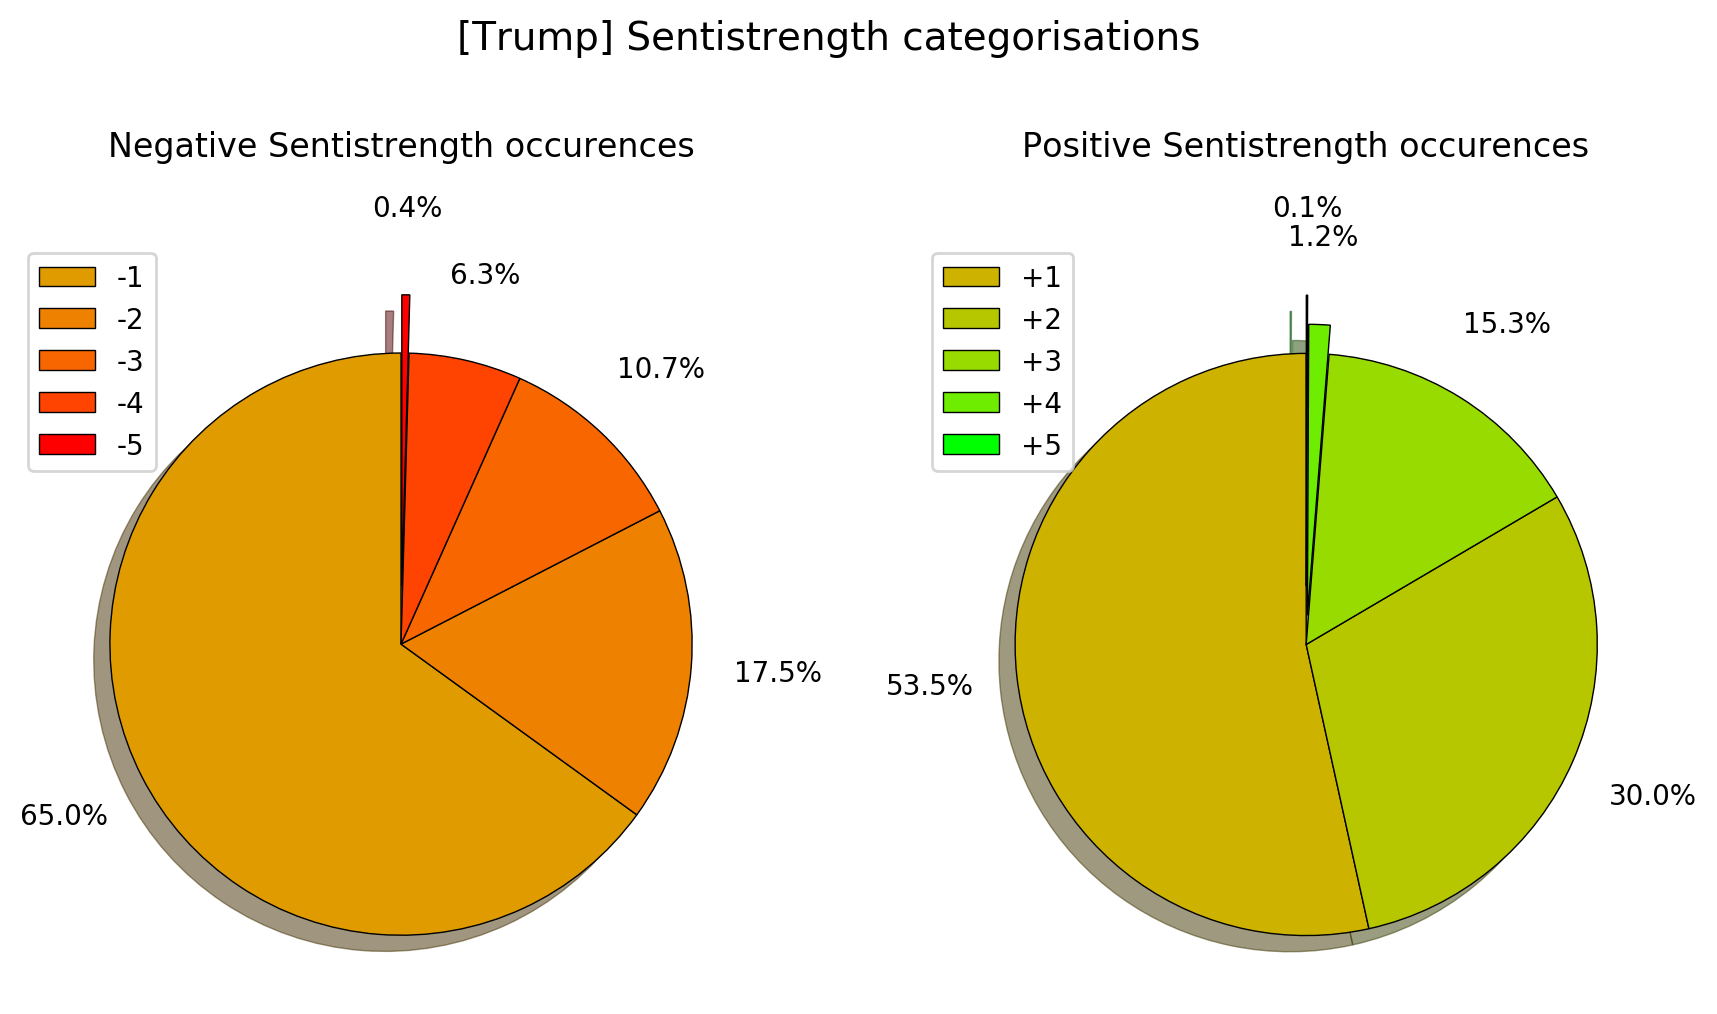

In [32]:
trump_valence_occurences_neg = []
trump_valence_occurences_pos = []
for i in range(0,5):
    trump_valence_occurences_neg.append(df_trump_pt[df_trump_pt.sen_neg == i].shape[0])
    trump_valence_occurences_pos.append(df_trump_pt[df_trump_pt.sen_pos == i].shape[0])
#, orient='index', columns=["valence_occurences"])

explode = [(0.0, 0.0, 0.0, 0.0, 0.2),(0.0, 0.0, 0.0, 0.1, 0.2)]
colors = [['#ff0000', '#fe4400', '#f86600', '#ee8200', '#df9b00'], ['#cdb200', '#b6c700',
          '#98db00', '#6fed00', '#00ff00']]

fig, axes = plt.subplots(1,2,figsize=(10,5))
fig.subplots_adjust(wspace = 0.4)
axes[0].pie(trump_valence_occurences_neg, shadow=True, colors=colors[0][::-1], startangle=90, autopct='%1.1f%%', pctdistance=1.3,
            wedgeprops={"edgecolor":"k",'linewidth': 0.5, 'linestyle': '-', 'antialiased': True}, explode=explode[0])
axes[0].axis('equal')
axes[0].legend(bbox_to_anchor=(-0.1, 1), loc='upper left', labels=[f"-{i}" for i in range(1,6)])
axes[0].set_title("Negative Sentistrength occurences", pad=30)

axes[1].pie(trump_valence_occurences_pos, shadow=True, colors=colors[1], startangle=90, autopct='%1.1f%%', pctdistance=1.3,
            wedgeprops={"edgecolor":"k",'linewidth': 0.5, 'linestyle': '-', 'antialiased': True}, explode=explode[1])
axes[1].axis('equal')
axes[1].legend(bbox_to_anchor=(-0.1, 1), loc='upper left', labels=[f"+{i}" for i in range(1,6)])
axes[1].set_title("Positive Sentistrength occurences", pad=30)
fig.suptitle('[Trump] Sentistrength categorisations', y=1.1, fontsize=14)
del colors, explode, trump_valence_occurences_neg, trump_valence_occurences_pos

## 4. Word clouds by valence, likes and retweets

In [33]:
def remove_links(tweet):
    new_tweet = tweet
    if 'http' in tweet:
        new_tweet = tweet[:tweet.find('http')]
    return new_tweet

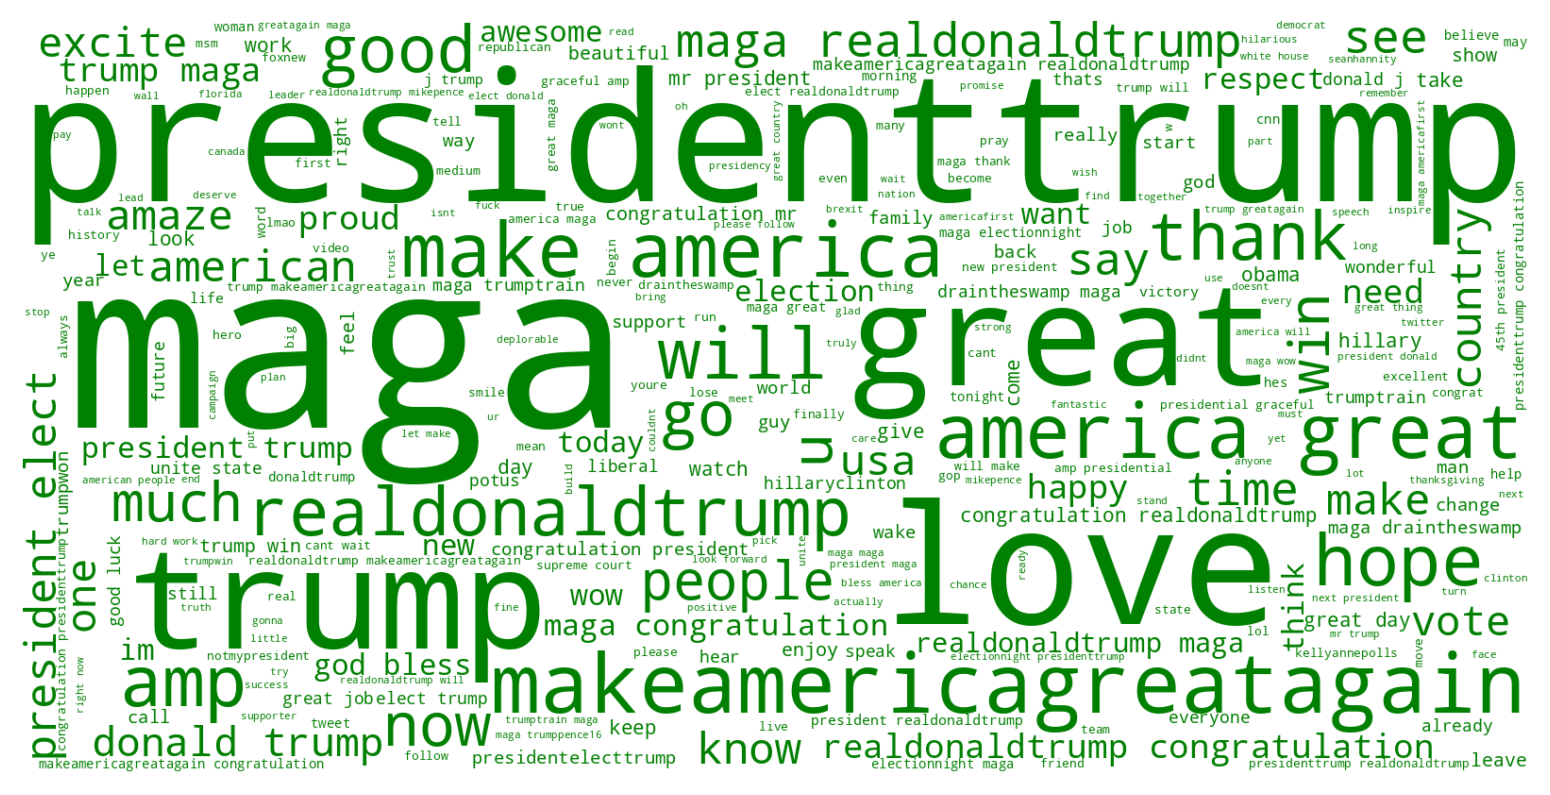

In [34]:
text = " ".join(remove_links(str(tweet)) for tweet in df_trumpText[df_trumpText.valence >= 2].tweet_body_lemmatized)
wordcloud = WordCloud(width=1600, height=800, max_words=300, max_font_size=250, background_color="white", color_func=lambda *args, **kwargs: "green", mode="RGBA").generate(text)

fig1, ax1 = plt.subplots(figsize=FIGSIZE)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis("off")
del text

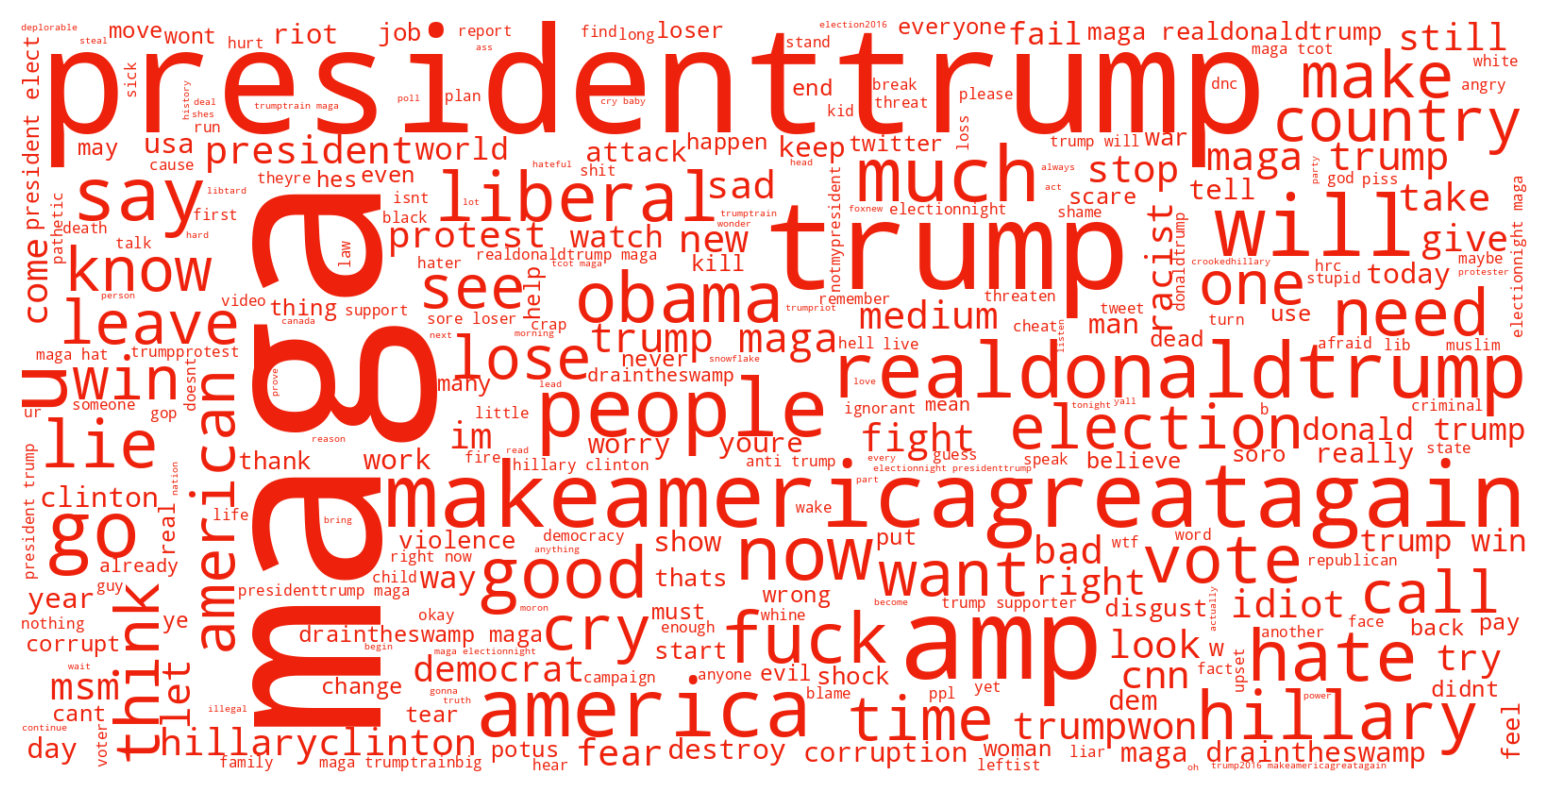

In [35]:
text = " ".join(remove_links(str(tweet)) for tweet in df_trumpText[df_trumpText.valence <= -2].tweet_body_lemmatized)
wordcloud = WordCloud(width=1600, height=800, max_words=300, max_font_size=250, background_color="white", color_func=lambda *args, **kwargs: (238,34,12), mode="RGBA").generate(text)

fig1, ax1 = plt.subplots(figsize=FIGSIZE)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis("off")
del text

---
---
---

# Hillary Dataset

## A. Preprocessing of `hillary_anonymise_cleaned.csv`

Loading `hilary_anonymise_cleaned.csv` in `df_hillary`:

In [36]:
df_hillary = pd.read_csv(ORIGINAL_FILES_PATH['hillary_anonymise_cleaned.csv'])
df_hillary = df_hillary.drop(df_hillary.columns[0], axis=1)

Reverting logarithmic transform of retweets and likes:

In [37]:
df_hillary[['retweets_log','likes_log']] = np.exp(df_hillary[['retweets_log','likes_log']]).subtract(1).astype(int)
df_hillary = df_hillary.rename(columns={'retweets_log': 'retweets', 'likes_log': 'likes'})

Printing first five rows:

In [38]:
df_hillary

,user_id,tweet_id,retweets,likes,followers,time,sen_pos,sen_neg
0,BDSVULEWGI,YRSGNEAVXF,0,0,84,2016-11-09 00:28:04,1,0
1,IXPJUSTNAQ,MKNAIWODXH,0,0,164,2016-11-09 00:33:23,0,2
2,AJOQDFRUVH,YXOMEQULJP,0,2,477,2016-11-09 00:45:39,0,0
3,FCLBODYSXR,PWQBDNSOCG,0,0,2,2016-11-09 00:51:32,0,0
4,THEYWOJDGF,VQBSRUDLJA,0,0,360,2016-11-09 01:07:57,0,0
...,...,...,...,...,...,...,...,...
346725,JYCGXWBHOF,QMXSWGOCDI,0,0,9,2016-11-16 00:27:41,0,2
346726,NAEXHMDPZQ,DNUXCPKQAR,0,0,183,2016-11-16 00:27:28,0,1
346727,CEHYLQOSNU,YTZDHKPESQ,0,0,12,2016-11-16 00:27:32,0,2
346728,TJHAWKYGRS,JBOXIYSARN,0,0,51,2016-11-16 00:27:38,0,1


## B. Used DataFrames

### "Per user" DataFrames

Per user Dataframes have names that finish with `_pu`.

Dataframes that describes the number of tweets (with retweets) and the number of original tweets (without retweets) per user:

In [39]:
df_hillary_tweets = pd.DataFrame(df_hillary['user_id'].value_counts())
df_hillary_tweets = df_hillary_tweets.rename(columns={'user_id': 'num_tweets'})

df_hillary_original_tweets = pd.DataFrame(df_hillary.sort_values("time").drop_duplicates(subset="tweet_id",keep='first')['user_id'].value_counts())
df_hillary_original_tweets = df_hillary_original_tweets.rename(columns={'user_id': 'num_original_tweets'})

df_hillary_total_original_tweets = pd.merge(df_hillary_tweets, df_hillary_original_tweets, left_index=True, right_index=True)

Dataframes that describe the number of followers, accumulated likes and accumulated retweets per user:

In [40]:
df_hillary_followers_pu = df_hillary.sort_values("time")[['user_id','followers']].drop_duplicates(subset='user_id',keep='last')
df_hillary_followers_pu.set_index('user_id', inplace=True)

df_hillary_likes_retweets_pu = df_hillary.sort_values("time")[['user_id','likes','retweets']]
df_hillary_likes_retweets_pu = df_hillary_likes_retweets_pu.groupby('user_id').agg({'likes':'sum','retweets':'sum'})

Dataframe that combines all per user dataframes:

In [41]:
df_hillary_pu = pd.merge(df_hillary_followers_pu, df_hillary_likes_retweets_pu, left_index=True, right_index=True)
df_hillary_pu = pd.merge(df_hillary_total_original_tweets, df_hillary_pu, left_index=True, right_index=True)
df_hillary_pu.index.name = 'user_id'

df_hillary_pu

,num_tweets,num_original_tweets,followers,likes,retweets
user_id,,,,,
AIZRJGNTMB,528,528,510,4,38
LYCPMKGEHA,402,402,87,6,6
XUYAPODIJW,379,379,12352,502,537
YHLWPFSVTZ,334,334,4656,223,215
LMQPCHZVSE,333,333,5903,591,264
...,...,...,...,...,...
FUXEJGRMWV,1,1,210,2,0
TMZREYQHBW,1,1,206,0,0
FPXJESOQTR,1,1,235,0,0


### "Per tweet" DataFrames

Per tweet Dataframes have names that finish with `_pt`.

In [42]:
df_hillary_pt = df_hillary[["tweet_id","retweets","likes","sen_pos","sen_neg"]].groupby('tweet_id').agg({'retweets':'sum','likes':'sum','sen_pos':'mean','sen_neg':'mean'})
assert df_hillary_pt[~pd.to_numeric(df_hillary_pt['sen_pos'], errors='coerce').notna()].empty
df_hillary_pt = df_hillary_pt.astype({"sen_pos": int, "sen_neg": int})

df_hillary_pt

,retweets,likes,sen_pos,sen_neg
tweet_id,,,,
ABCDLPHRGX,0,0,0,0
ABCEGDXLNH,0,0,0,0
ABCEWGHJMU,0,7,0,0
ABCHQTWXYG,0,0,0,0
ABCIHZWVPU,0,2,0,3
...,...,...,...,...
ZYXSPCQBUA,3,5,0,2
ZYXUCVTORF,0,0,0,1
ZYXUMTOREH,0,0,1,1


## C. Used Variables

Variable that returns which columns have `NaN` values:

In [43]:
hillary_col_has_NaN = dict(zip(df_hillary.columns.values, [df_hillary[col].isnull().values.any() for col in df_hillary.columns]))
for col in hillary_col_has_NaN:
    print(f"{col:>20}: {hillary_col_has_NaN[col]}")

             user_id: False
            tweet_id: False
            retweets: False
               likes: False
           followers: False
                time: False
             sen_pos: False
             sen_neg: False


Non `NaN` user ids, unique users, average tweets (with retweets) per user, average original (without retweets) tweet per user:

In [44]:
hillary_num_non_NaN_users = df_hillary['user_id'].count()
hillary_num_unique_users = df_hillary['user_id'].nunique()
hillary_num_tweets = df_hillary.shape[0]
hillary_num_original_tweets = df_hillary_original_tweets.sum(0)[0]

## 1. Analysis of originality of tweets

Some statistics:

In [45]:
print(f"{'Total users ids':<40} {hillary_num_non_NaN_users:,.0f}",
      f"{'Unique users ids':<40} {hillary_num_unique_users:,.0f}",
      f"{'Unique users percentage':<40} {hillary_num_unique_users/hillary_num_non_NaN_users:.2%}",
      "\n",
      f"{'Total tweets':<40} {hillary_num_tweets:,.0f}",
      f"{'Original tweets':<40} {hillary_num_original_tweets:,.0f}",
      f"{'Original tweets percentage':<40} {hillary_num_original_tweets/hillary_num_tweets:.2%}",
      "\n",
      f"{'Average tweet per user':<40} {hillary_num_tweets/hillary_num_unique_users:.5}",
      f"{'Average original tweet per user':<40} {hillary_num_original_tweets/hillary_num_unique_users:.5f}",
      sep="\n")

Total users ids                          346,730
Unique users ids                         157,645
Unique users percentage                  45.47%


Total tweets                             346,730
Original tweets                          346,717
Original tweets percentage               100.00%


Average tweet per user                   2.1994
Average original tweet per user          2.19935


Comparison between the amount of original tweets and the amound of retweets:

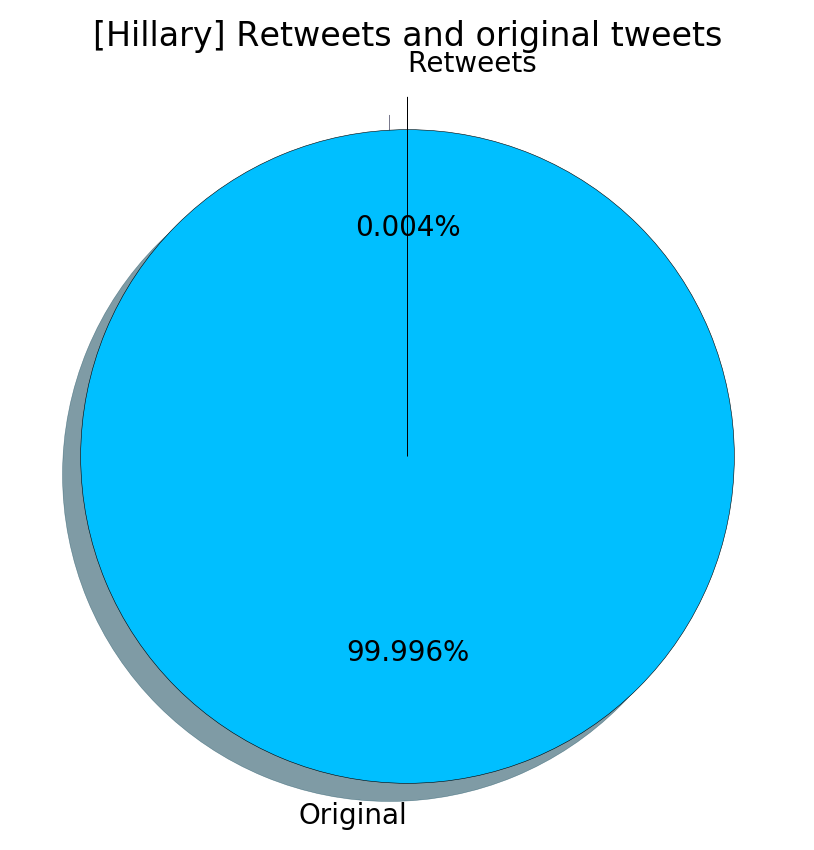

In [46]:
labels = "Original", "Retweets"
sizes = [hillary_num_original_tweets, hillary_num_tweets - hillary_num_original_tweets]
explode = (0.1, 0)

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, explode=explode, labels=labels, shadow=True, startangle=90, autopct='%1.3f%%',colors=COLORS_DEMOCRATS, wedgeprops={"edgecolor":"k",'linewidth': 0.2, 'linestyle': '-', 'antialiased': True})
ax1.axis('equal')
ax1.set(title="[Hillary] Retweets and original tweets")
del labels, sizes, explode

##### Amount of total tweets and original tweets of top 300 users with most tweets:

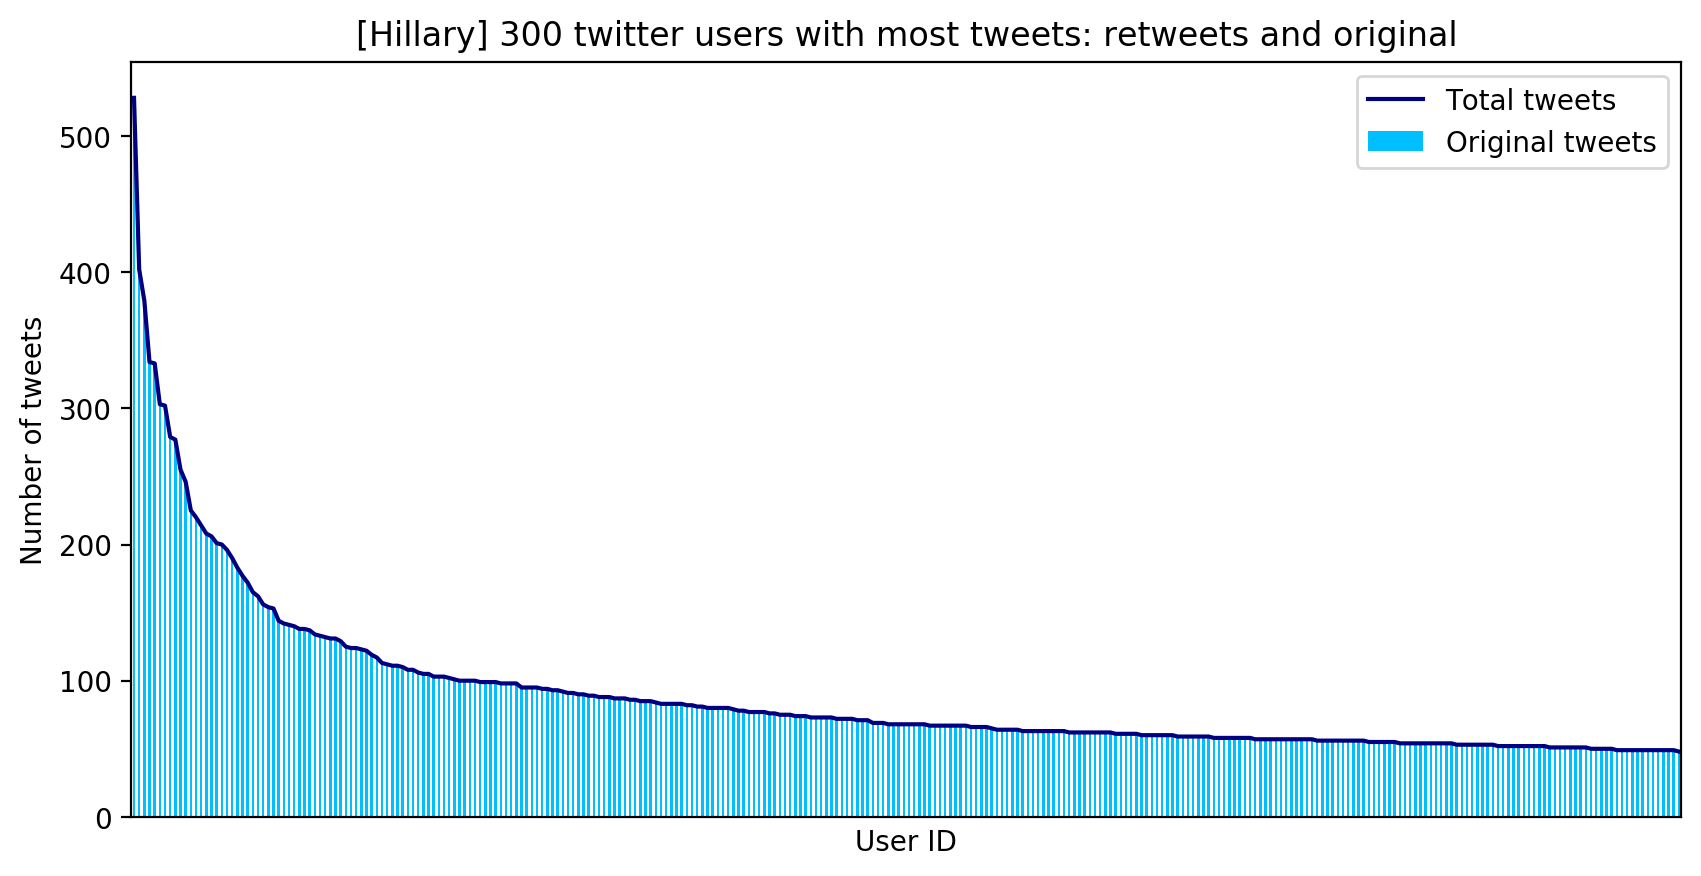

In [47]:
df = df_hillary_total_original_tweets.head(300)
fig1, ax1 = plt.subplots(figsize=FIGSIZE)
df["num_tweets"].plot(ax=ax1, xticks=[], label="Total tweets", color=COLORS_DEMOCRATS[1])
df["num_original_tweets"].plot(ax=ax1, xticks=[], kind='bar', label="Original tweets", color=COLORS_DEMOCRATS[0])
ax1.legend()
ax1.set(title=f"[Hillary] 300 twitter users with most tweets: retweets and original", xlabel="User ID", ylabel="Number of tweets")
del df

## 2. Analysis of accumulated tweets, followers, likes, retweets per user

Some statististics:

In [48]:
print(f"{' ':20}{'min':>5}{'max':>15}{'mean':>15}{'median':>15}{'std.-dev.':>15}")
for column in df_hillary_pu:
    current_column = df_hillary_pu[column]
    print(f"{column:^20}{current_column.min():>5}{current_column.max():>15,.0f}{current_column.mean():>15,.1f}{current_column.median():>15,.0f}{current_column.std():>15,.1f}")

                      min            max           mean         median      std.-dev.
     num_tweets         1            528            2.2              1            5.6
num_original_tweets     1            528            2.2              1            5.6
     followers          0     16,488,841        3,089.5            220       77,117.7
       likes            0        258,554           20.1              0          756.3
      retweets          0        154,494           12.6              0          476.3


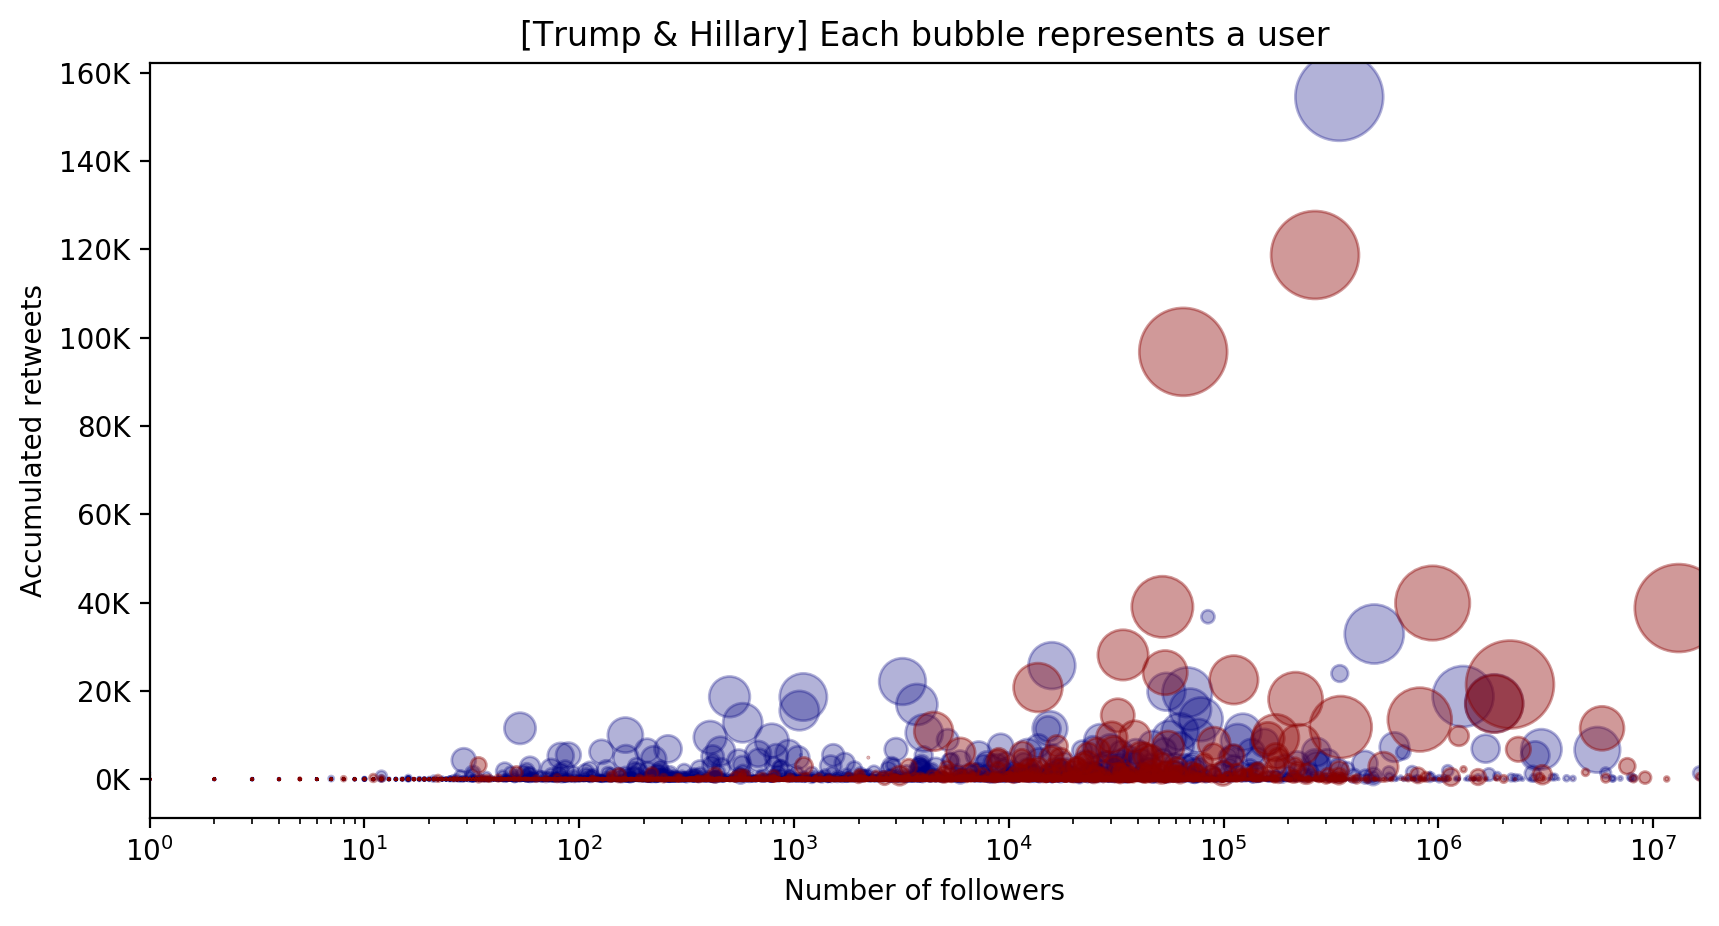

In [49]:
fig1, ax1 = plt.subplots(figsize=(10,5))

df = df_hillary_pu
df = df[df["likes"] >= 1]
sizes = df['likes'].clip(upper=100000) /100
ax1.scatter(x = df['followers'].values, y = df['retweets'].values, s = sizes.values, c=COLORS_DEMOCRATS[1], alpha=0.3);

df = df_trump_pu
df = df[df["likes"] >= 1]
sizes = df['likes'].clip(upper=100000) /100
ax1.scatter(x = df['followers'].values, y = df['retweets'].values, s = sizes.values, c=COLORS_REPUBLICAN[1], alpha=0.4);

ax1.set_xlim([1, df['followers'].max()])
ax1.set_xscale('log')
ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax1.get_yticks()/1000]
ax1.set_yticklabels(ylabels)

ax1.set(xlabel="Number of followers",ylabel="Accumulated retweets")
ax1.set_title("[Trump & Hillary] Each bubble represents a user")
del df, sizes

Comparison plot:

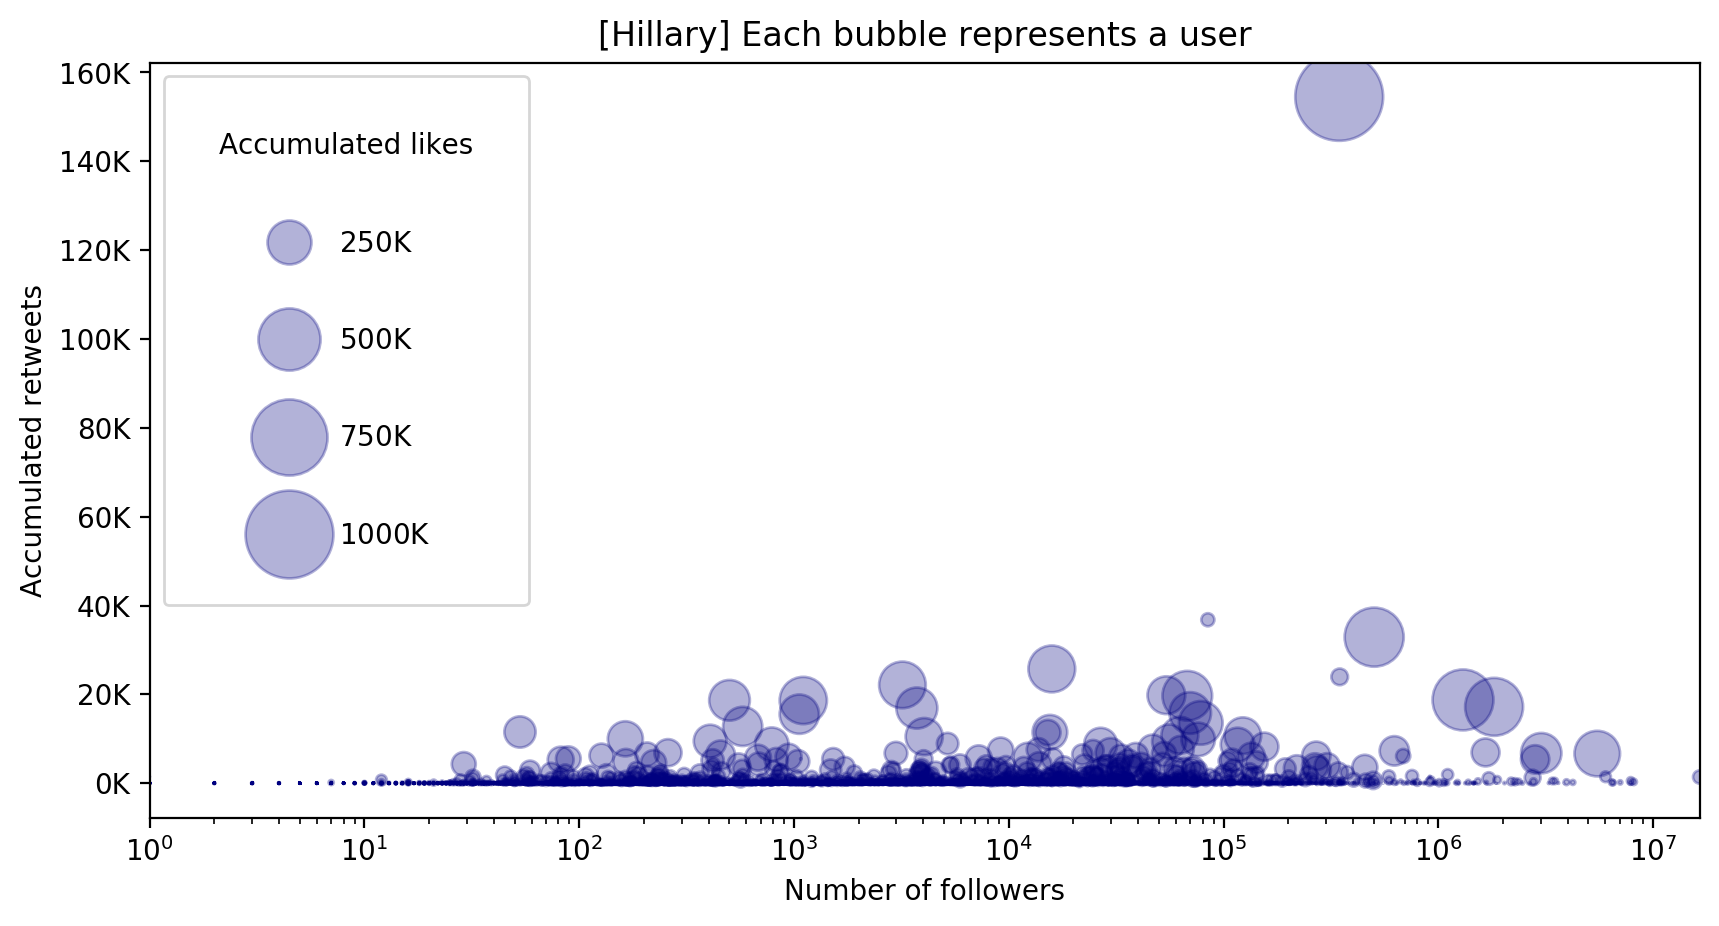

In [50]:
df = df_hillary_pu
df = df[df["likes"] >= 1]
sizes = df['likes'].clip(upper=100000) /100
fig1, ax1 = plt.subplots(figsize=(10,5))
sc = ax1.scatter(x = df['followers'].values, y = df['retweets'].values, s = sizes.values, c=COLORS_DEMOCRATS[1], alpha=0.3);
ax1.set_xlim([1, df['followers'].max()])
ax1.set_xscale('log')
ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax1.get_yticks()/1000]
ax1.set_yticklabels(ylabels)
legend_elements = sc.legend_elements("sizes", num=4, c=COLORS_DEMOCRATS[1])
for i,legend_label in enumerate(legend_elements[1]):
    legend_elements[1][i] = legend_label+'K'
ax1.legend(*legend_elements, title="Accumulated likes", labelspacing=2.5, borderpad=2)
ax1.set(xlabel="Number of followers",ylabel="Accumulated retweets")#, suptitle="Each bubble represents a user")
ax1.set_title("[Hillary] Each bubble represents a user")
del df, sizes, legend_elements

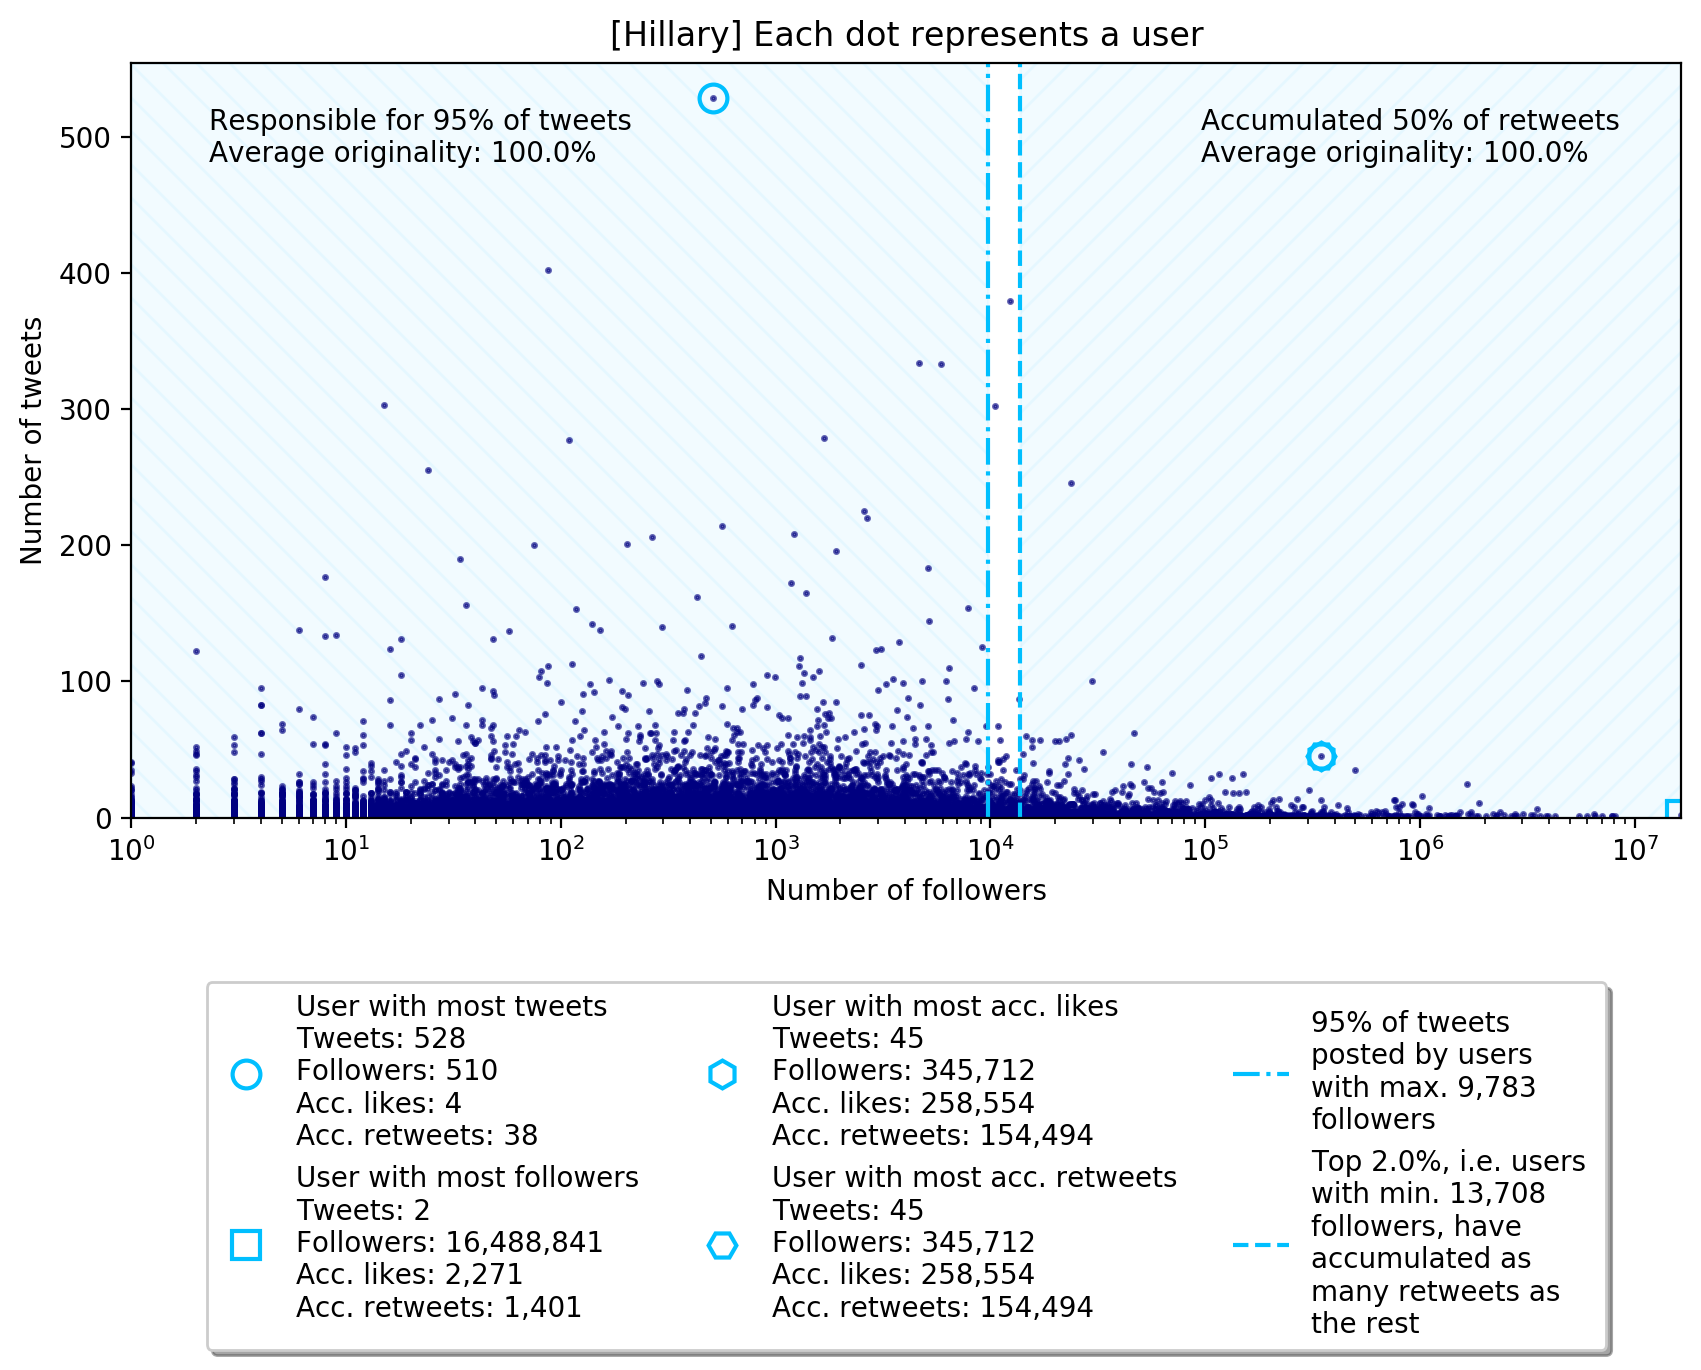

In [51]:
df = df_hillary_pu.sort_values("followers")
df = df[(df["followers"] >= 1)]

fig1, ax1 = plt.subplots(figsize=FIGSIZE)

ax1.plot(df['followers'].values, df['num_tweets'].values, '.', color=COLORS_DEMOCRATS[1], markersize=3, alpha=0.6)

ax1.set_xlim([1, df['followers'].max()])
ax1.set_ylim(ymin=0)
ax1.set_xscale('log')
ax1.set(xlabel="Number of followers",ylabel="Number of tweets",title="[Hillary] Each dot represents a user")

most_tweets_id = df_hillary_pu["num_tweets"].idxmax()
ax1.plot(df.loc[most_tweets_id]['followers'], df.loc[most_tweets_id]['num_tweets'], 'o', fillstyle='none', color=COLORS_DEMOCRATS[0], markersize=10, markeredgewidth=1.5,
         label=f"User with most tweets\nTweets: {df.loc[most_tweets_id]['num_tweets']:,.0f}\nFollowers: {df.loc[most_tweets_id]['followers']:,.0f}\nAcc. likes: {df.loc[most_tweets_id]['likes']:,.0f}\nAcc. retweets: {df.loc[most_tweets_id]['retweets']:,.0f}")

most_followers_id = df_hillary_pu["followers"].idxmax()
ax1.plot(df.loc[most_followers_id]['followers'], df.loc[most_followers_id]['num_tweets'], 's', fillstyle='none', color=COLORS_DEMOCRATS[0], markersize=10, markeredgewidth=1.5,
         label=f"User with most followers\nTweets: {df.loc[most_followers_id]['num_tweets']:,.0f}\nFollowers: {df.loc[most_followers_id]['followers']:,.0f}\nAcc. likes: {df.loc[most_followers_id]['likes']:,.0f}\nAcc. retweets: {df.loc[most_followers_id]['retweets']:,.0f}")
ax1.legend(loc='upper center', fancybox=True, shadow=True, bbox_to_anchor=(0.5, -0.2), ncol=3)

most_likes_id = df_hillary_pu["likes"].idxmax()
ax1.plot(df.loc[most_likes_id]['followers'], df.loc[most_likes_id]['num_tweets'], 'h', fillstyle='none', color=COLORS_DEMOCRATS[0], markersize=10, markeredgewidth=1.5,
         label=f"User with most acc. likes\nTweets: {df.loc[most_likes_id]['num_tweets']:,.0f}\nFollowers: {df.loc[most_likes_id]['followers']:,.0f}\nAcc. likes: {df.loc[most_likes_id]['likes']:,.0f}\nAcc. retweets: {df.loc[most_likes_id]['retweets']:,.0f}")
ax1.legend(loc='upper center', fancybox=True, shadow=True, bbox_to_anchor=(0.5, -0.2), ncol=3)

most_retweets_id = df_hillary_pu["retweets"].idxmax()
ax1.plot(df.loc[most_retweets_id]['followers'], df.loc[most_retweets_id]['num_tweets'], 'H', fillstyle='none', color=COLORS_DEMOCRATS[0], markersize=10, markeredgewidth=1.5,
         label=f"User with most acc. retweets\nTweets: {df.loc[most_retweets_id]['num_tweets']:,.0f}\nFollowers: {df.loc[most_retweets_id]['followers']:,.0f}\nAcc. likes: {df.loc[most_retweets_id]['likes']:,.0f}\nAcc. retweets: {df.loc[most_retweets_id]['retweets']:,.0f}")

percentile_tweets_sel = df['num_tweets'].cumsum() >= hillary_num_tweets*0.95
percentile_tweets_loc = df['followers'][df[percentile_tweets_sel].index[0]]
ax1.axvline(x=percentile_tweets_loc, color=COLORS_DEMOCRATS[0], linestyle="-.", label=f"95% of tweets\nposted by users\nwith max. {percentile_tweets_loc:,.0f}\nfollowers")
plt.axvspan(1, percentile_tweets_loc, color=COLORS_DEMOCRATS[0], alpha=0.05, hatch=r"\\")
plt.text(0.05, 0.86,f'Responsible for 95% of tweets\nAverage originality: { df["num_original_tweets"][percentile_tweets_sel].sum() / df["num_tweets"][percentile_tweets_sel].sum() * 100:.1f}%',
         horizontalalignment='left', verticalalignment='bottom', transform = ax1.transAxes)

percentile_retweets_sel = df['retweets'].cumsum() >= df['retweets'].sum()*0.50
percent_retweets = (percentile_retweets_sel.value_counts()[True] / hillary_num_unique_users)*100
percentile_retweets_loc = df['followers'][df[percentile_retweets_sel].index[0]]
ax1.axvline(x=percentile_retweets_loc, color=COLORS_DEMOCRATS[0], linestyle="--", label=f"Top {percent_retweets:.1f}%, i.e. users \nwith min. {percentile_retweets_loc:,.0f}\nfollowers, have\naccumulated as\nmany retweets as\nthe rest")
plt.axvspan(percentile_retweets_loc, df['followers'].max(), color=COLORS_DEMOCRATS[0], alpha=0.05, hatch=r"//")
plt.text(1-0.31, 0.86,f'Accumulated 50% of retweets\nAverage originality: { df["num_original_tweets"][percentile_retweets_sel].sum() / df["num_tweets"][percentile_retweets_sel].sum() * 100:.1f}%',
         horizontalalignment='left', verticalalignment='bottom', transform = ax1.transAxes)

ax1.legend(loc='upper center', fancybox=True, shadow=True, bbox_to_anchor=(0.5, -0.2), ncol=3)
del df, percentile_tweets_loc